# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

top50_chart_df = pd.read_excel("chartmx_03_20.xlsx", index = False)
stats_df = pd.read_excel("audiofmx.xlsx", index = False)

top50_chart_df["id"] = top50_chart_df["URL"].str[-22:]

top50_chart_df = top50_chart_df[["Position", "Track Name", "Artist", "Date", "id"]]

top50_chart_df.head()

,Position,Track Name,Artist,Date,id
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-01,0mb7btREdC3wuIUmuVRgWn
1,2,El Año Viejo,Tony Camargo,2017-01-01,6NjhADkaWwGYO0R7eZXyI4
2,3,La Edad de los Países,Hernán Casciari,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi
3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,2017-01-01,2Q0WZoJaRJlelcxqOvowUc
4,5,Another Day Of Sun,La La Land Cast,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ


In [2]:
stats_df = stats_df[["acousticness", "danceability", "duration_ms", "energy", "id", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]
stats_df.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
0,0.00703,0.591,187853,0.901,0mb7btREdC3wuIUmuVRgWn,0.000000,10,0.0649,-4.328,0,0.1500,175.345,4,audio_features,0.694
1,0.60200,0.740,182720,0.521,6NjhADkaWwGYO0R7eZXyI4,0.000000,0,0.1110,-10.663,1,0.3650,159.694,4,audio_features,0.904
2,0.92300,0.606,280521,0.301,5gA5Tvu7zlihzqUvmPUqoi,0.000000,9,0.2970,-15.735,0,0.8610,62.876,3,audio_features,0.941
3,0.11600,0.741,120560,0.913,2Q0WZoJaRJlelcxqOvowUc,0.000001,11,0.0783,-5.453,1,0.2780,160.070,4,audio_features,0.854
4,0.01620,0.588,228173,0.742,5kRBzRZmZTXVg8okC7SJFZ,0.000004,8,0.6530,-6.757,1,0.0528,125.819,4,audio_features,0.824


In [3]:
complete_df = top50_chart_df.merge(stats_df, on = "id")
complete_df = complete_df[["Position", "Track Name", "Artist", "Date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]
complete_df.head()

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-01,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
1,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-02,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
2,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-03,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
3,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-04,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
4,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-05,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694


## Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:

## If the tempo of a song is higher than 100 bpm, then it will be more popular.

## If the chooses to release a reggaeton song, then it will remain in the Top 50 Chart throughout the next year.

## If a song has a higher level of energy, then it will be more likely to be in the Top 50 throughout the next year.

In [4]:
energy=complete_df.iloc[:,7]
position=complete_df.iloc[:,0]
correlation =stats.pearsonr(energy,position)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.01


y =-1.17x + 26.39
The r-squared is: 0.00022066912514121623


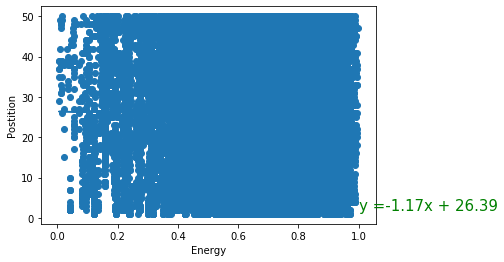

In [5]:
x_values=complete_df["energy"]
y_values=complete_df["Position"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values,y_values)
regress_values = x_values* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy")
plt.ylabel("Postition")

print(f"The r-squared is: {rvalue**2}")

plt.show()

In [6]:
#The sample can explain the behavior of the population
subset=complete_df.sample(90)
subset

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
1008,22,Pa Ti,Bad Bunny,2017-01-17,0.348000,0.766,191295,0.715,0.00000,1,0.0980,-3.025,1,0.2310,128.085,4,audio_features,0.5550
29752,34,Lost on You,LP,2019-07-17,0.100000,0.433,268105,0.724,0.00000,5,0.0918,-6.126,0,0.0372,174.006,4,audio_features,0.6890
26955,46,Jackie Chan,Tiësto,2018-07-13,0.374000,0.747,215760,0.834,0.00000,3,0.0586,-2.867,0,0.0450,128.005,4,audio_features,0.6870
24279,44,Rytm,Alejandro Fernandez,2018-04-14,0.000293,0.810,391181,0.717,0.90200,10,0.1660,-13.059,0,0.0585,124.019,4,audio_features,0.1570
18040,9,Scooby Doo Pa Pa,Dj Kass,2017-12-24,0.039600,0.910,145972,0.754,0.00154,10,0.1220,-2.573,0,0.2390,120.939,4,audio_features,0.6300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8716,35,Bonita,J Balvin,2017-07-21,0.010600,0.782,265747,0.868,0.00252,5,0.2900,-1.715,0,0.0400,96.042,4,audio_features,0.8840
12118,46,Que Va,Alex Sensation,2018-01-02,0.130000,0.771,238160,0.835,0.00000,0,0.0601,-3.388,1,0.0507,91.012,4,audio_features,0.8170
30331,21,In My Feelings,Drake,2018-08-18,0.058900,0.835,217925,0.626,0.00006,1,0.3960,-5.833,1,0.1250,91.030,4,audio_features,0.3500
28780,6,Nonstop,Drake,2018-07-07,0.030600,0.909,238613,0.405,0.00698,6,0.1050,-8.133,0,0.1400,154.984,4,audio_features,0.4550


In [7]:
energy_sample=subset.iloc[:,7]
position_sample=subset.iloc[:,0]
correlation =stats.pearsonr(energy_sample,position_sample)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is 0.18


In [ ]:
#There is no correlation between the energy and the Position of the song.
#The higher the energy does not affect the position of any song. 

y =14.44x + 15.57
The r-squared is: 0.03168337959582217


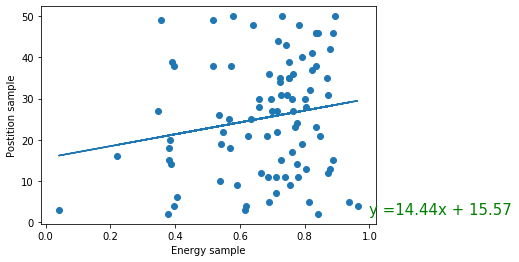

In [8]:
x_values=subset["energy"]
y_values=subset["Position"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values,y_values)
regress_values = x_values* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy sample")
plt.ylabel("Postition sample")

print(f"The r-squared is: {rvalue**2}")

plt.show()

In [11]:
max_energy=complete_df["energy"].max()
min_energy=complete_df["energy"].min()
median_energy=complete_df["energy"].median()
print(f"The max value of energy is {max_energy}")
print(f"The min value of energy is {min_energy}")
print(f"The median value of energy is {median_energy}")

The max value of energy is 0.997
The min value of energy is 0.00426
The median value of energy is 0.689


In [12]:
energy_higher_value=complete_df["energy"]>=0.689
tab_energy_higher_value=complete_df[energy_higher_value]
tab_energy_higher_value

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-01,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.150,175.345,4,audio_features,0.694
1,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-02,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.150,175.345,4,audio_features,0.694
2,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-03,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.150,175.345,4,audio_features,0.694
3,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-04,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.150,175.345,4,audio_features,0.694
4,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-05,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.150,175.345,4,audio_features,0.694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44697,49,Mañana Es Too Late,Jesse & Joy,2019-05-26,0.26200,0.710,195213,0.772,0.0,11,0.3570,-3.291,0,0.162,183.957,4,audio_features,0.867
44698,47,Mañana Es Too Late,Jesse & Joy,2019-05-30,0.26200,0.710,195213,0.772,0.0,11,0.3570,-3.291,0,0.162,183.957,4,audio_features,0.867
44852,44,Presiento,Morat,2019-05-10,0.16800,0.711,174380,0.727,0.0,2,0.2960,-3.150,1,0.162,180.039,4,audio_features,0.465
44853,44,Presiento,Morat,2019-05-11,0.16800,0.711,174380,0.727,0.0,2,0.2960,-3.150,1,0.162,180.039,4,audio_features,0.465


In [13]:
energy_h=tab_energy_higher_value.iloc[:,7]
position_h=tab_energy_higher_value.iloc[:,0]
correlation =stats.pearsonr(energy_h,position_h)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.01


In [ ]:
#There is no correlation between the energy and the Position of the song.
#The higher the energy does not affect the position of any song. 

## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

In [9]:
dance_sample=subset.iloc[:,5]
position_sample=subset.iloc[:,0]
correlation =stats.pearsonr(dance_sample,position_sample)
print(f"The correlation between both factors is {round(correlation[0],2)}")

The correlation between both factors is -0.23


In [ ]:
#There is no correlation between the danceability and the position of the song. 
#The higher the danceability does not affect the position of any song.

y =-19.27x + 38.22
The r-squared is: 0.05493423983806882


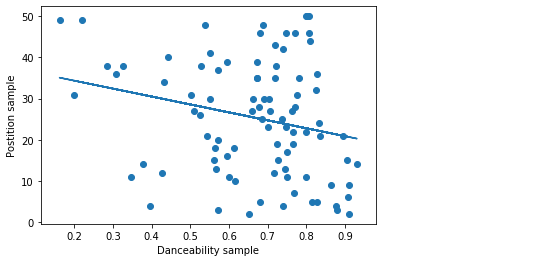

In [10]:
x_values=subset["danceability"]
y_values=subset["Position"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values,y_values)
regress_values = x_values* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Danceability sample")
plt.ylabel("Postition sample")

print(f"The r-squared is: {rvalue**2}")

plt.show()